### List of Libraries

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


### Hyper Parameters

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigma_begin = 30.0
sigma_end = 0.01
num_levels = 10
batch_size = 64
learning_rate = 2e-4
epochs = 30
langevin_steps = 150
step_lr = 2e-5

### Loading Dataset

We perform a linear transformation to scale the pixel values to a range of **[-1, 1]**

* **Mean ():** 0.5
* **Standard Deviation ():** 0.5

When we use `transforms.ToTensor()`, our image pixels (originally 0 to 255) are converted into floating-point numbers between **0 and 1**.

When `Normalize((0.5,), (0.5,))` is applied:

* **Minimum value (0):** 
* **Maximum value (1):** 
* **Middle value (0.5):** 

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [38]:
for batch in train_loader:
    images, _ = batch
    image = images[0]
    print(image.shape)
    print(f"image min is {image.min()}")
    print(f"image max is {image.max()}")
    break

torch.Size([1, 28, 28])
image min is -1.0
image max is 1.0


### Squence of Noise Levels

The model uses these during the training and sampling process. A geometric sequence (log-linear) is used to find the middle level noises.

In [39]:
log_start = np.log(sigma_begin)
log_end = np.log(sigma_end)

log_levels = np.linspace(log_start, log_end, num_levels)


sigma_sequence = np.exp(log_levels)

sigmas = torch.tensor(sigma_sequence)

sigmas = sigmas.float().to(device)

print(f"Noise Sequence: {sigmas}")

Noise Sequence: tensor([3.0000e+01, 1.2325e+01, 5.0632e+00, 2.0801e+00, 8.5454e-01, 3.5106e-01,
        1.4422e-01, 5.9251e-02, 2.4341e-02, 1.0000e-02], device='cuda:0')


### Project into higher-dim space

This class "stretches" the single number $\sigma$ into a 512-dimensional space using periodic functions (sine and cosine). Without this, the network might struggle to distinguish between a noise level of 0.01 and 0.02, as the difference is numerically tiny. By projecting it into a high-dimensional "Fourier" space, these small differences become distinct patterns the network can recognize

In [40]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embedding_size=256, scale=sigma_begin):
        super().__init__()
        self.register_buffer("W", torch.randn(embedding_size) * scale)

    def forward(self, sigma):
        sigma = sigma[:, None]
        proj = sigma * self.W[None, :] * 2 * math.pi
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

### Adaptive Residual Block

In [41]:
class AdaptiveResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        
        self.norm1 = nn.GroupNorm(8, in_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        self.emb = nn.Linear(emb_dim, 2 * out_channels) 
        
        self.skip = (
            nn.Conv2d(in_channels, out_channels, 1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x, emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        style = self.emb(emb)
        scale, shift = style.chunk(2, dim=1)
        scale = scale[:, :, None, None]
        shift = shift[:, :, None, None]
        
        h = self.norm2(h)
        h = h * (1 + scale) + shift
        h = F.silu(h)
        
        h = self.conv2(h)
        return h + self.skip(x)

### ScoreNet

In [42]:
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Sequential(
            GaussianFourierProjection(256),
            nn.Linear(512, 256),
            nn.SiLU()
        )

        self.input_conv = nn.Conv2d(1, 64, 3, padding=1)
       
        self.enc1 = AdaptiveResBlock(64, 64)
        self.enc2 = AdaptiveResBlock(64, 128)
        self.enc3 = AdaptiveResBlock(128, 256)

        self.downsample = nn.AvgPool2d(2)

        self.dec1 = AdaptiveResBlock(384, 128) 
        self.dec2 = AdaptiveResBlock(192, 64) 

        self.out_conv = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, sigma):
        emb = self.embed(sigma)

        h1 = self.enc1(self.input_conv(x), emb)
        h2 = self.enc2(self.downsample(h1), emb)
        h3 = self.enc3(self.downsample(h2), emb)

        h = F.interpolate(h3, scale_factor=2, mode="nearest")
        h = torch.cat([h, h2], dim=1)
        h = self.dec1(h, emb)

        h = F.interpolate(h, scale_factor=2, mode="nearest")
        h = torch.cat([h, h1], dim=1)
        h = self.dec2(h, emb)

        return self.out_conv(h) / sigma[:, None, None, None]

### Training Loop

Random Sigma Sampling:
We don't train on just one noise level at a time. For every batch, we randomly pick a $\sigma$ from our geometric list for each image.

Weighting ($L = \sigma^2 \cdot MSE$): The loss is weighted by $\sigma^2$. Since the magnitude of the score is roughly $1/\sigma$, multiplying by $\sigma$ (and then squaring in the MSE) ensures 

that the loss values are roughly the same scale for both $\sigma=30$ and $\sigma=0.01$.

Target Calculation: For a Gaussian distribution $q(x_{noisy} | x) = \mathcal{N}(x, \sigma^2 I)$, the 

true score is exactly $\frac{x - x_{noisy}}{\sigma^2}$, which simplifies to $-\frac{noise}{\sigma}$

Epoch 1/30 | Loss: 113.7602
Epoch 2/30 | Loss: 60.8699
Epoch 3/30 | Loss: 55.7938
Epoch 4/30 | Loss: 53.2979
Epoch 5/30 | Loss: 52.8301
Epoch 6/30 | Loss: 51.9522
Epoch 7/30 | Loss: 51.1129
Epoch 8/30 | Loss: 50.7629
Epoch 9/30 | Loss: 50.2014
Epoch 10/30 | Loss: 49.6190
Epoch 11/30 | Loss: 49.4625
Epoch 12/30 | Loss: 49.3036
Epoch 13/30 | Loss: 49.1789
Epoch 14/30 | Loss: 48.7887
Epoch 15/30 | Loss: 48.3909
Epoch 16/30 | Loss: 48.3308
Epoch 17/30 | Loss: 48.2893
Epoch 18/30 | Loss: 47.4532
Epoch 19/30 | Loss: 47.8705
Epoch 20/30 | Loss: 47.5344
Epoch 21/30 | Loss: 47.4303
Epoch 22/30 | Loss: 47.0365
Epoch 23/30 | Loss: 47.1167
Epoch 24/30 | Loss: 47.2674
Epoch 25/30 | Loss: 46.9591
Epoch 26/30 | Loss: 46.8035
Epoch 27/30 | Loss: 46.8856
Epoch 28/30 | Loss: 46.8903
Epoch 29/30 | Loss: 46.7938
Epoch 30/30 | Loss: 46.6228


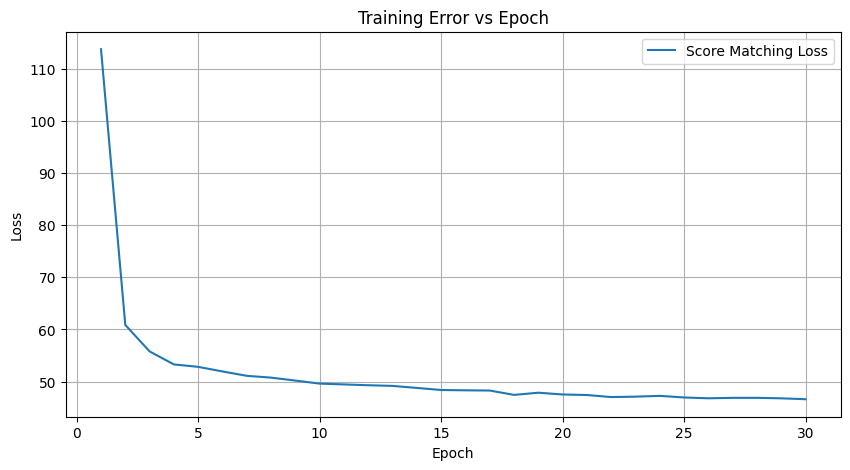

In [43]:
model = ScoreNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        
        labels = torch.randint(0, len(sigmas), (x.shape[0],)).to(device)
        used_sigmas = sigmas[labels] 
        sigmas_reshaped = used_sigmas.view(-1, 1, 1, 1)
        
        noise = torch.randn_like(x)
        perturbed_x = x + sigmas_reshaped * noise
        
        score = model(perturbed_x, used_sigmas)
        target = -noise / sigmas_reshaped
        

        sq_diff = (score - target) ** 2
        sum_sq_diff = sq_diff.sum(dim=[1, 2, 3])
        
        loss = (sum_sq_diff * (used_sigmas ** 2)).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, label='Score Matching Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Error vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [48]:
def annealed_langevin_dynamics(model, sigmas, steps=150, lr=2e-5):
    was_training = model.training
    model.eval()
    
    for p in model.parameters():
        p.requires_grad = False
        
    had_gradients_enabled = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
    
    x = torch.randn(16, 1, 28, 28).to(device)
    evolution_samples = []

    for sigma in sigmas:
        alpha = lr * (sigma / sigmas[-1])**2
        
        for t in range(steps):
            z = torch.randn_like(x)
            score = model(x, sigma.expand(x.shape[0]))
            
            x.data.add_(alpha * score + torch.sqrt(2 * alpha) * z)
        
        x.data.clamp_(-1.0, 1.0)    
        evolution_samples.append(x[:3].detach().cpu().clone())

    for p in model.parameters():
        p.requires_grad = True
    if was_training:
        model.train()
    torch.set_grad_enabled(had_gradients_enabled)

    return x.detach(), evolution_samples

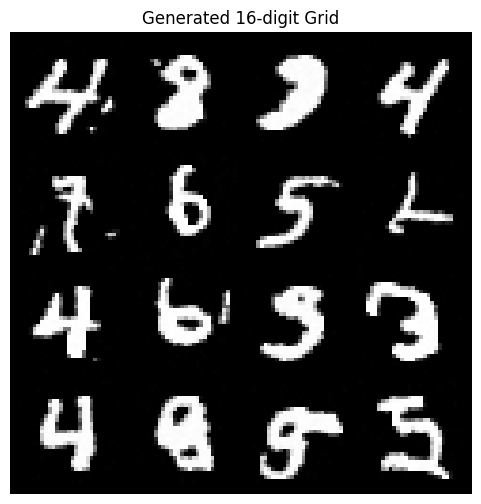

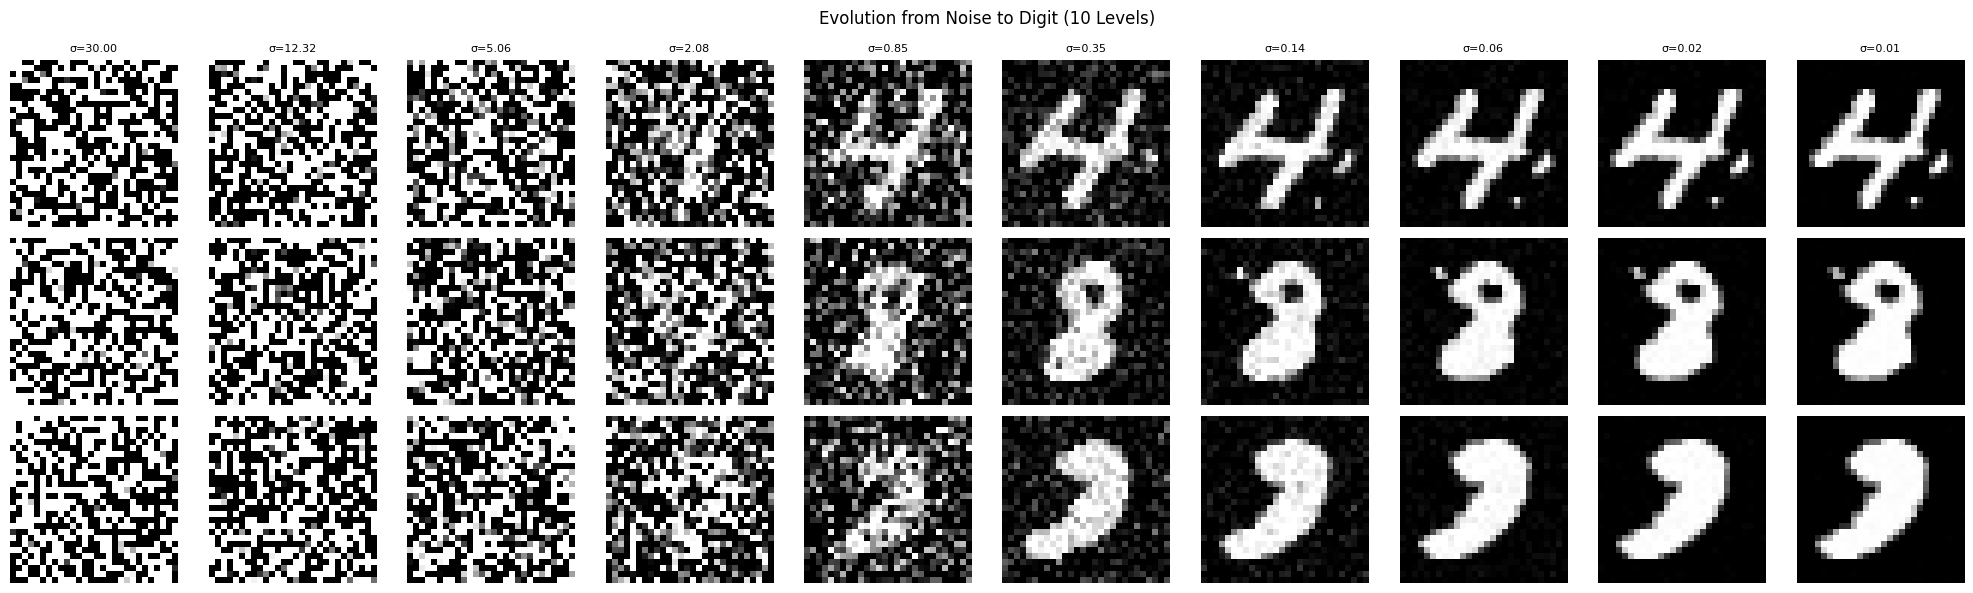

In [49]:
final_samples, evolution = annealed_langevin_dynamics(model, sigmas)

grid = make_grid(final_samples, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Generated 16-digit Grid")
plt.axis('off')
plt.show()

fig, axes = plt.subplots(3, num_levels, figsize=(num_levels * 2, 6))
for sample_idx in range(3):
    for sigma_idx in range(num_levels):
        img = evolution[sigma_idx][sample_idx].squeeze()
        ax = axes[sample_idx, sigma_idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        if sample_idx == 0:
            ax.set_title(f"σ={sigmas[sigma_idx]:.2f}", fontsize=8)

plt.suptitle(f"Evolution from Noise to Digit ({num_levels} Levels)")
plt.tight_layout()
plt.show()

### Conditional ScoreNet

In [54]:
class ConditionalScoreNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.noise_embed = nn.Sequential(
            GaussianFourierProjection(256),
            nn.Linear(512, 256),
            nn.SiLU()
        )
        
        self.class_embed = nn.Embedding(10, embed_dim)

        self.input_conv = nn.Conv2d(1, 64, 3, padding=1)
        
        self.enc1 = AdaptiveResBlock(64, 64)
        self.enc2 = AdaptiveResBlock(64, 128)
        self.enc3 = AdaptiveResBlock(128, 256)
        self.downsample = nn.AvgPool2d(2)

        self.dec1 = AdaptiveResBlock(384, 128)
        self.dec2 = AdaptiveResBlock(192, 64)

        self.out_conv = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, sigma, labels):
        n_emb = self.noise_embed(sigma)
        c_emb = self.class_embed(labels)
        
        combined_emb = n_emb + c_emb 

        h1 = self.enc1(self.input_conv(x), combined_emb)
        h2 = self.enc2(self.downsample(h1), combined_emb)
        h3 = self.enc3(self.downsample(h2), combined_emb)

        h = F.interpolate(h3, scale_factor=2, mode="nearest")
        h = torch.cat([h, h2], dim=1)
        h = self.dec1(h, combined_emb)

        h = F.interpolate(h, scale_factor=2, mode="nearest")
        h = torch.cat([h, h1], dim=1)
        h = self.dec2(h, combined_emb)

        return self.out_conv(h) / sigma[:, None, None, None]

### Training Loop

Epoch 1/30 | Cond Loss: 121.0594
Epoch 2/30 | Cond Loss: 62.0151
Epoch 3/30 | Cond Loss: 57.1984
Epoch 4/30 | Cond Loss: 54.5587
Epoch 5/30 | Cond Loss: 52.6789
Epoch 6/30 | Cond Loss: 52.2740
Epoch 7/30 | Cond Loss: 50.8554
Epoch 8/30 | Cond Loss: 50.6970
Epoch 9/30 | Cond Loss: 50.1950
Epoch 10/30 | Cond Loss: 49.6790
Epoch 11/30 | Cond Loss: 49.3649
Epoch 12/30 | Cond Loss: 49.1068
Epoch 13/30 | Cond Loss: 48.6100
Epoch 14/30 | Cond Loss: 48.4610
Epoch 15/30 | Cond Loss: 48.3729
Epoch 16/30 | Cond Loss: 48.2187
Epoch 17/30 | Cond Loss: 47.5667
Epoch 18/30 | Cond Loss: 47.9215
Epoch 19/30 | Cond Loss: 47.8261
Epoch 20/30 | Cond Loss: 47.5314
Epoch 21/30 | Cond Loss: 47.4752
Epoch 22/30 | Cond Loss: 47.1746
Epoch 23/30 | Cond Loss: 46.9583
Epoch 24/30 | Cond Loss: 46.8480
Epoch 25/30 | Cond Loss: 47.2321
Epoch 26/30 | Cond Loss: 47.1240
Epoch 27/30 | Cond Loss: 46.9265
Epoch 28/30 | Cond Loss: 46.5138
Epoch 29/30 | Cond Loss: 46.6138
Epoch 30/30 | Cond Loss: 46.3073


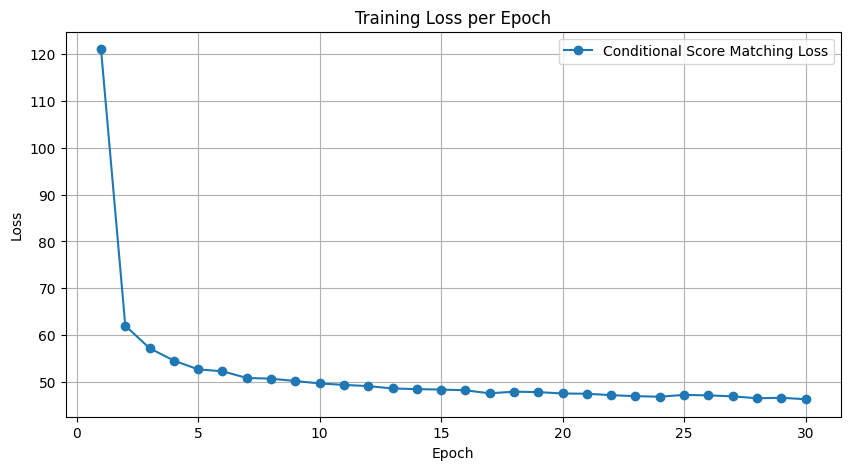

In [56]:
cond_model = ConditionalScoreNet().to(device)
optimizer = optim.Adam(cond_model.parameters(), lr=learning_rate)
loss_history_cond = []

for epoch in range(epochs):
    cond_model.train()
    epoch_loss = 0
    
    for x, labels in train_loader:
        x, labels = x.to(device), labels.to(device)
        
        idx = torch.randint(0, len(sigmas), (x.shape[0],)).to(device)
        used_sigmas = sigmas[idx]
        sigmas_reshaped = used_sigmas.view(-1, 1, 1, 1)
        
        noise = torch.randn_like(x)
        perturbed_x = x + sigmas_reshaped * noise
        
        score = cond_model(perturbed_x, used_sigmas, labels)
        target = -noise / sigmas_reshaped
        
        sq_diff = (score - target) ** 2
        sum_sq_diff = sq_diff.sum(dim=[1, 2, 3])
        loss = (sum_sq_diff * (used_sigmas ** 2)).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history_cond.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{epochs} | Cond Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history_cond, label='Conditional Score Matching Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [57]:
def conditional_sampling(model, sigmas, labels, steps=langevin_steps, lr=step_lr):
    was_training = model.training
    model.eval()
    
    for p in model.parameters():
        p.requires_grad = False
        
    had_gradients_enabled = torch.is_grad_enabled()
    torch.set_grad_enabled(True)
    
    x = torch.randn(len(labels), 1, 28, 28).to(device)
    
    for sigma in sigmas:
        alpha = lr * (sigma / sigmas[-1])**2
        
        for t in range(steps):
            z = torch.randn_like(x)

            score = model(x, sigma.expand(len(labels)), labels)
            
            x.data.add_(alpha * score + torch.sqrt(2 * alpha) * z)
            
        x.data.clamp_(-1.0, 1.0)
            
    for p in model.parameters():
        p.requires_grad = True
        
    if was_training:
        model.train()
        
    torch.set_grad_enabled(had_gradients_enabled)

    return x.detach()

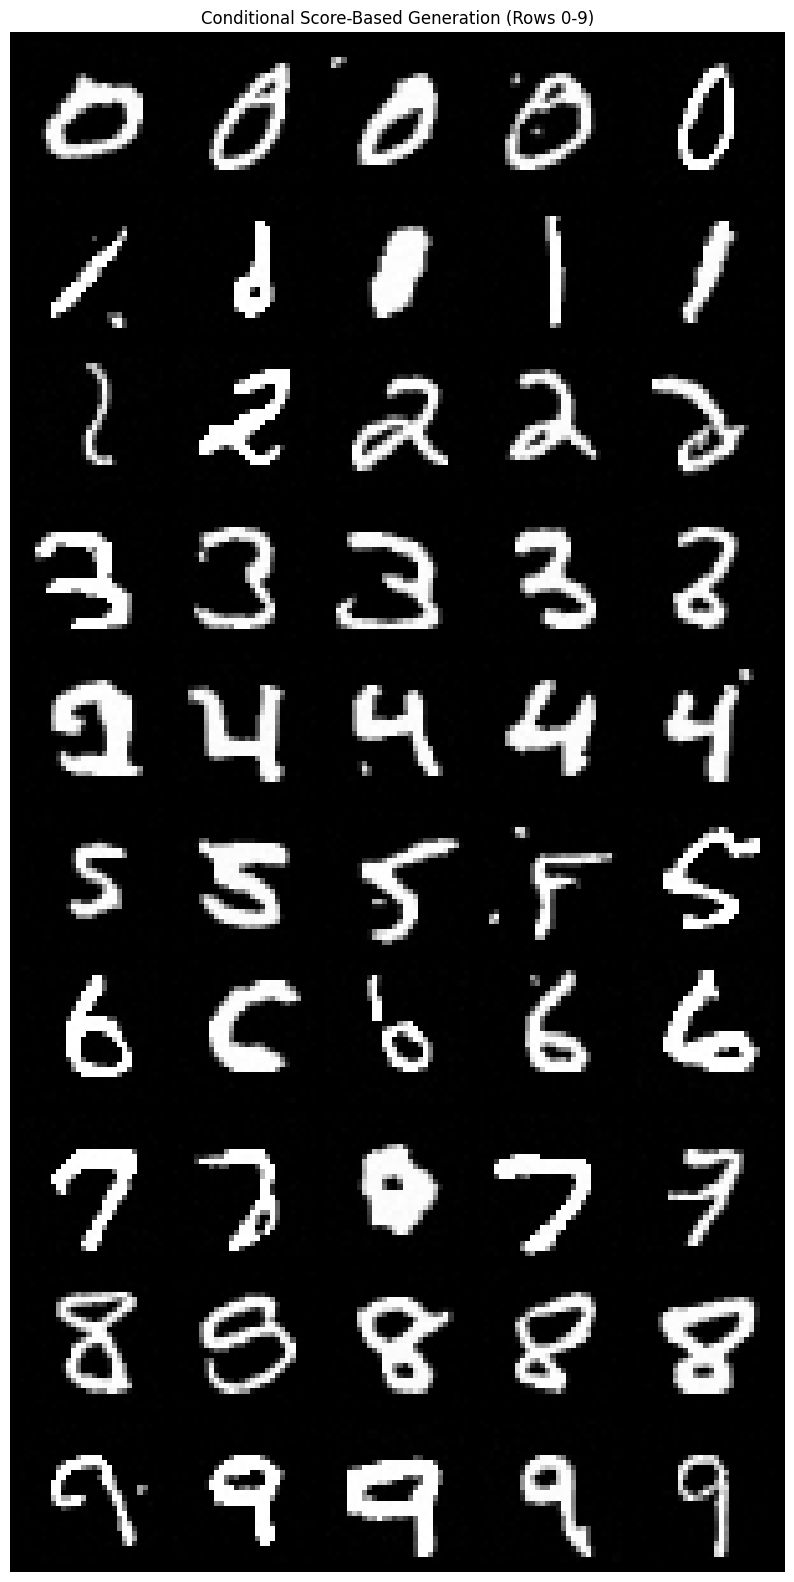

In [58]:
num_classes = 10
samples_per_class = 5
target_labels = torch.arange(num_classes).repeat_interleave(samples_per_class).to(device)

final_conditional_samples = conditional_sampling(cond_model, sigmas, target_labels)

grid = make_grid(final_conditional_samples, nrow=5, normalize=True)

plt.figure(figsize=(10, 20))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Conditional Score-Based Generation (Rows 0-9)")
plt.axis('off')
plt.show()